In [53]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

import re
import string
import time
import csv

from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import matplotlib.cm as cm

import matplotlib.pyplot as plt

from scipy import stats
import scikit_posthocs as sp
import seaborn as sns

import sys
import inspect
import types

import scipy.cluster.hierarchy as spc

import matplotlib.ticker as ticker

In [5]:
df_java = pd.read_csv('../metrics_nonezero_nonefork_v7.csv', index_col=0)

In [6]:
# exclude features not used during clustering
df_java = df_java.drop(columns=['license_body_kw', 'author_body_kw', 'deprecate_body_kw', 'moved_body_kw', 'moved_header_kw', 'project_name_header_non_empty', 'feature_header_kw', 'configure_header_kw', 'dependency_header_kw', 'reference_header_kw', 'release_header_kw', 'changelog_header_kw', 'question_header_kw', 'issue_header_kw', 'note_header_kw'])

In [7]:
df_java.shape

(14901, 27)

In [8]:
def normalize_features(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df_minmax = min_max_scaler.fit_transform(df)
    return df_minmax

In [9]:
df_java.columns[5:]

Index(['isEnglishReadme', 'readme_header_count', 'readme_code_block_count',
       'readme_image_count', 'readme_url_count', 'project_name_header_kw',
       'description_header_kw', 'content_header_kw', 'install_header_kw',
       'usage_header_kw', 'contribut_header_kw', 'credit_header_kw',
       'license_header_kw', 'test_header_kw', 'document_header_kw',
       'archive_header_kw', 'example_header_kw', 'author_header_kw',
       'troubleshoot_header_kw', 'screenshot_header_kw', 'deprecate_header_kw',
       'readme_tokens_count'],
      dtype='object')

In [10]:
normalized_metrics = normalize_features(df_java[df_java.columns.values[5:]])

In [11]:
df_normalized = pd.DataFrame(normalized_metrics)
df_normalized.columns = df_java.columns.values[5:]

In [12]:
df_normalized.head()

,isEnglishReadme,readme_header_count,readme_code_block_count,readme_image_count,readme_url_count,project_name_header_kw,description_header_kw,content_header_kw,install_header_kw,usage_header_kw,contribut_header_kw,credit_header_kw,license_header_kw,test_header_kw,document_header_kw,archive_header_kw,example_header_kw,author_header_kw,troubleshoot_header_kw,screenshot_header_kw,deprecate_header_kw,readme_tokens_count
0,1.0,0.002813,0.001089,0.000000,0.002255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000958
1,1.0,0.012658,0.018519,0.000000,0.011274,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.028915
2,1.0,0.009845,0.009804,0.003906,0.020293,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010512
3,0.0,0.015471,0.000000,0.027344,0.023675,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.014058
4,0.0,0.054852,0.066449,0.000000,0.067644,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.092559


In [13]:
def run(df, metrics, eps=0.5):
    # Compute DBSCAN
    t1 = time.time()
    db = DBSCAN(eps=eps, min_samples=10, metric='cosine', n_jobs=-1).fit(metrics)
    t2 = time.time()
    print("Time to do clustering", len(df), "java projects:", (t2 - t1) / 60, "min")

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)

    #   plot_tsne_pca(text, labels)

    df['cluster_eps_' + str(eps)] = labels

In [14]:
ns = 10
nbrs = NearestNeighbors(n_neighbors=ns, metric='cosine').fit(normalized_metrics)
distances, indices = nbrs.kneighbors(normalized_metrics)
distanceDec = sorted(distances[:,ns-1], reverse=True)

Text(0.5, 0, 'Repositories')

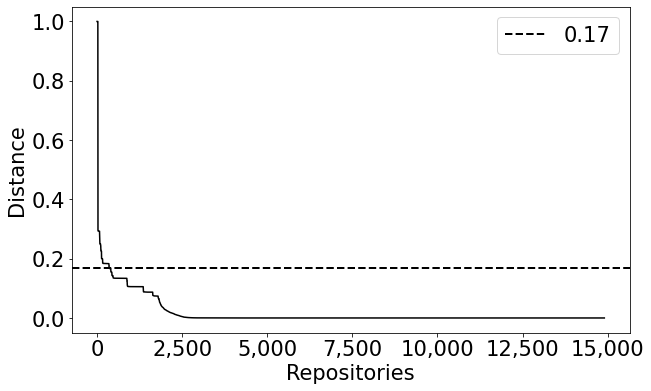

In [15]:
plt.rcParams.update({'font.size': 21})


fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(list(range(1,normalized_metrics.shape[0]+1)), distanceDec, color='k')
  
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.axhline(linestyle='dashed', label="horizontal", linewidth=2, color='k', y=0.17)
  
  
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles = handles[:1], labels = ['0.17'])

plt.ylabel('Distance')
plt.xlabel('Repositories')

In [18]:
i=0.17
run(df_java, normalized_metrics, i)
df_java['cluster_eps_{}'.format(i)].value_counts()

Time to do clustering 14901 java projects: 0.077035125096639 min
Estimated number of clusters: 32
Estimated number of noise points: 185


 1     4350
 0     3515
 5     2872
 4     1234
 11    1171
 2      375
 6      251
-1      185
 8      145
 3      119
 10     110
 19      61
 26      45
 7       38
 12      36
 13      35
 16      34
 15      33
 23      31
 31      31
 28      30
 22      26
 24      23
 17      22
 20      21
 25      18
 9       17
 21      16
 27      13
 14      12
 29      11
 30      11
 18      10
Name: cluster_eps_0.17, dtype: int64

### Analysis

In [19]:
df_normalized = df_java.drop(columns=['id','name', 'url', 'forked_from', 'stars', 'cluster_eps_{}'.format(i)])

In [20]:
df_normalized['cluster'] = df_java['cluster_eps_{}'.format(i)]

In [21]:
df_normalized.head()

,isEnglishReadme,readme_header_count,readme_code_block_count,readme_image_count,readme_url_count,project_name_header_kw,description_header_kw,content_header_kw,install_header_kw,usage_header_kw,contribut_header_kw,credit_header_kw,license_header_kw,test_header_kw,document_header_kw,archive_header_kw,example_header_kw,author_header_kw,troubleshoot_header_kw,screenshot_header_kw,deprecate_header_kw,readme_tokens_count,cluster
6,1,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,0
15,1,9,17,0,10,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,905,1
16,1,7,9,1,18,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,329,1
41,0,11,0,7,21,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,440,1
42,0,39,61,0,60,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,2897,1


In [22]:
# sort clusters by size
df_normalized.groupby('cluster').isEnglishReadme.describe().sort_values(by = 'count', ascending=False).index.values

array([ 1,  0,  5,  4, 11,  2,  6, -1,  8,  3, 10, 19, 26,  7, 12, 13, 16,
       15, 23, 31, 28, 22, 24, 17, 20, 25,  9, 21, 27, 14, 29, 30, 18],
      dtype=int64)

In [23]:
df_sorted_cluster_size_metrics = pd.merge(df_normalized.groupby('cluster').agg('mean'), df_java['cluster_eps_{}'.format(i)].value_counts().to_frame(), left_index=True, right_index=True)

In [25]:
cols = list(df_sorted_cluster_size_metrics.columns)
cols = [cols[-1]] + cols[:-1]
df_sorted_cluster_size_metrics = df_sorted_cluster_size_metrics[cols]

cols = df_sorted_cluster_size_metrics.columns

In [26]:
df_sorted_cluster_size_metrics.head().round().astype(int)

,cluster_eps_0.17,isEnglishReadme,readme_header_count,readme_code_block_count,readme_image_count,readme_url_count,project_name_header_kw,description_header_kw,content_header_kw,install_header_kw,usage_header_kw,contribut_header_kw,credit_header_kw,license_header_kw,test_header_kw,document_header_kw,archive_header_kw,example_header_kw,author_header_kw,troubleshoot_header_kw,screenshot_header_kw,deprecate_header_kw,readme_tokens_count
-1,185,0,10,11,3,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,690
0,3515,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,87
1,4350,1,9,10,1,7,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,476
2,375,1,5,6,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,286
3,119,1,4,3,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,232


In [27]:
shorted_cols = list(map(lambda x: x.replace('Readme','').replace('readme_','').replace('header_',''), cols))
shorted_cols[0] = 'Size'
shorted_cols[2] = 'header_count'

In [28]:
df_sorted_cluster_size_metrics.columns = shorted_cols

In [29]:
df_sorted_cluster_size_metrics = df_sorted_cluster_size_metrics[['isEnglish', 'project_name_kw', 'description_kw', 'content_kw', 'install_kw', 'usage_kw', 'contribut_kw', 'credit_kw', 'license_kw', 'test_kw', 'document_kw', 'archive_kw', 'example_kw', 'author_kw', 'troubleshoot_kw', 'screenshot_kw', 'deprecate_kw', 'header_count', 'code_block_count', 'image_count', 'url_count', 'tokens_count', 'Size']]

In [30]:
df_sorted_cluster_size_metrics[df_sorted_cluster_size_metrics.columns[0:-6]] = df_sorted_cluster_size_metrics[df_sorted_cluster_size_metrics.columns[0:-6]] * 100

In [31]:
cols = list(df_sorted_cluster_size_metrics.columns)
cols = [cols[-1]] + cols[:-1]
df_sorted_cluster_size_metrics = df_sorted_cluster_size_metrics[cols]

In [32]:
df_sorted_cluster_size_metrics.sum()

Size                14901.000000
isEnglish            1506.260951
project_name_kw       856.592731
description_kw        348.082013
content_kw            114.155328
install_kw            564.672880
usage_kw              583.711712
contribut_kw          126.385834
credit_kw             115.086052
license_kw            551.468779
test_kw               319.303510
document_kw           128.101895
archive_kw              3.944703
example_kw            338.767319
author_kw             113.625349
troubleshoot_kw         4.415657
screenshot_kw         117.409133
deprecate_kw            8.372165
header_count          196.308307
code_block_count      177.565530
image_count            47.586778
url_count             159.470776
tokens_count         9241.756316
dtype: float64

In [33]:
df_sorted_cluster_size_metrics[df_sorted_cluster_size_metrics.index > -1].round().astype(int).groupby('isEnglish').describe()[['header_count', 'code_block_count', 'image_count', 'url_count']]

header_count                                               code_block_count                                                    image_count                                              url_count                                               
                 count      mean       std  min  25%  50%  75%   max            count       mean       std   min   25%   50%   75%   max       count      mean       std  min  25%  50%  75%  max     count      mean       std  min  25%  50%   75%   max
isEnglish                                                                                                                                                                                                                                                 
0                 17.0  7.647059  2.177762  3.0  6.0  8.0  9.0  11.0             17.0   7.529412  5.209578   1.0   4.0   5.0  12.0  18.0        17.0  1.882353  1.053705  1.0  1.0  1.0  3.0  4.0      17.0  5.705882  5.046839  2.0  3.0  5.0  7.00  23.0
92                 1.0  9.000000       NaN  9.0  9.0  9.0  9.0   9.0              1.0  10.000000       NaN  10.0  10.0  10.0  10.0  10.0         1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0       1.0  7.000000       NaN  7.0  7.0  7.0  7.00   7.0
100               14.0  3.357143  1.215739  1.0  3.0  3.5  4.0   5.0             14.0   2.142857  1.833750   0.0   1.0   1.5   3.0   6.0        14.0  0.785714  0.699293  0.0  0.0  1.0  1.0  2.0      14.0  3.000000  1.754116  1.0  2.0  2.5  3.75   7.0

In [34]:
df_t_99 = df_sorted_cluster_size_metrics[df_sorted_cluster_size_metrics.index > -1].round().astype(int)

In [35]:
df_t_99['Eng'] = df_t_99.isEnglish > 0

In [36]:
df_t_99.groupby('Eng').describe()[['header_count', 'code_block_count', 'image_count', 'url_count']]

header_count                                               code_block_count                                                image_count                                              url_count                                              
             count      mean       std  min  25%  50%  75%   max            count      mean       std  min  25%  50%   75%   max       count      mean       std  min  25%  50%  75%  max     count      mean       std  min  25%  50%  75%   max
Eng                                                                                                                                                                                                                                              
False         17.0  7.647059  2.177762  3.0  6.0  8.0  9.0  11.0             17.0  7.529412  5.209578  1.0  4.0  5.0  12.0  18.0        17.0  1.882353  1.053705  1.0  1.0  1.0  3.0  4.0      17.0  5.705882  5.046839  2.0  3.0  5.0  7.0  23.0
True          15.0  3.733333  1.869556  1.0  3.0  4.0  4.0   9.0             15.0  2.666667  2.690371  0.0  1.0  2.0   3.5  10.0        15.0  0.800000  0.676123  0.0  0.0  1.0  1.0  2.0      15.0  3.266667  1.980861  1.0  2.0  3.0  4.0   7.0

In [37]:
df_java[df_java['cluster_eps_0.17']>-1].groupby('isEnglishReadme').describe()

id                                                                                         forked_from                                       stars                                                     readme_header_count                                                 readme_code_block_count                                                 readme_image_count                                               readme_url_count                                                 project_name_header_kw                                              description_header_kw                                             content_header_kw                                              install_header_kw                                              usage_header_kw                                              contribut_header_kw                                              credit_header_kw                                              license_header_kw                                              test_header_kw                                              document_header_kw                                              archive_header_kw                                              example_header_kw                                              author_header_kw                                              troubleshoot_header_kw                                              screenshot_header_kw                                              deprecate_header_kw                                              readme_tokens_count                                                          cluster_eps_0.17                                               
                   count          mean           std     min          25%         50%           75%          max       count mean  std  min  25%  50%  75%  max    count       mean         std  min  25%  50%  75%      max               count      mean        std  min  25%  50%  75%    max                   count      mean        std  min  25%  50%  75%    max              count      mean       std  min  25%  50%  75%   max            count      mean        std  min  25%  50%  75%    max                  count      mean       std  min  25%  50%  75%  max                 count     mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max           count      mean       std  min  25%  50%  75%  max               count      mean       std  min  25%  50%  75%  max            count      mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max          count      mean       std  min  25%  50%  75%  max              count      mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max             count      mean       std  min  25%  50%  75%  max            count      mean       std  min  25%  50%  75%  max                  count      mean       std  min  25%  50%  75%  max                count      mean       std  min  25%  50%  75%  max               count      mean       std  min  25%  50%  75%  max               count        mean         std  min   25%   50%    75%      max            count      mean       std  min  25%  50%   75%   max
isEnglishReadme                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [39]:
sorted_cluster_ids = df_java.groupby('cluster_eps_{}'.format(i)).stars.describe().sort_values(by=['50%', '75%'],ascending=False).index

In [40]:
df_java_log = df_java.copy()
df_java_log.stars = np.log(df_java_log.stars)

In [41]:
eng_clusters = [0,5,2,6,8,3,10,12,15,23,28,25,14,18]
noneng_clusters = [4,11,19,26,7,13,16,31,22,24,17,20,9,21,27,29,30]
mixture_clusters = [1]
noise_clusters = [-1]

In [42]:
eng_color = 'darkgray'
noneng_color = 'whitesmoke'
mixture_color = 'black'

In [43]:
import matplotlib.patches as mpatches
eng_patch = mpatches.Patch(color=eng_color, label='all English tokens in ReadMe files')
noneng_patch = mpatches.Patch(color=noneng_color, label='some non-English tokens in ReadMe files')
mixture_patch = mpatches.Patch(color=mixture_color, label='mix of ReadMe files')

Text(0, 0.5, 'Stars (Logarithmic Transform)')

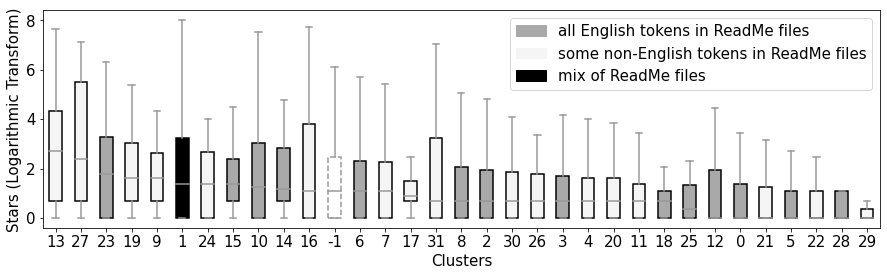

In [54]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15, 4))
# boxprops = dict(linestyle='--', linewidth=3)

# ax = sns.boxplot(y="stars", x='cluster_eps_{}'.format(i), data=df_java_log, color='white', width=.5, fliersize=2, showfliers=False)
ax = sns.boxplot(y="stars", x='cluster_eps_{}'.format(i), data=df_java_log, color='white', width=.5, fliersize=2,
                 showfliers=False, order=sorted_cluster_ids)

# ax = sns.boxplot(x='cluster_eps_{}'.format(i), y="stars", data=df_java)
# iterate over boxes
for ii, box in enumerate(ax.artists):
    if sorted_cluster_ids[ii] in eng_clusters:
        box.set_edgecolor('black')
        box.set_facecolor(eng_color)
    elif sorted_cluster_ids[ii] in noneng_clusters:
        box.set_edgecolor('black')
        box.set_facecolor(noneng_color)
    elif sorted_cluster_ids[ii] in mixture_clusters:
        box.set_edgecolor('black')
        box.set_facecolor(mixture_color)
    elif sorted_cluster_ids[ii] in noise_clusters:
        box.set_linestyle('--')
        # box.set_edgecolor('black')
        # box.set_facecolor(mixture_color)

        # # iterate over whiskers and median lines
        # for j in range(6*ii,6*(ii+1)):
        #      ax.lines[j].set_color('black')

plt.legend(handles=[eng_patch, noneng_patch, mixture_patch])

# plt.title('Distribution of number of stargazers over all clusters')
plt.xlabel('Clusters')
plt.ylabel('Stars (Logarithmic Transform)')

In [45]:
series_cluster_stars = df_java.groupby('cluster_eps_{}'.format(i)).apply(lambda x: x.stars.values.tolist())

In [47]:
nonnoisy_cluster_stars = series_cluster_stars[1:].values.tolist()

In [48]:
stats.kruskal(*nonnoisy_cluster_stars).pvalue.astype(str)

'1.450930224676792e-306'

In [49]:
stats.kruskal(nonnoisy_cluster_stars[0], nonnoisy_cluster_stars[6])

KruskalResult(statistic=45.98953691048344, pvalue=1.1888624434663381e-11)

In [55]:
dunn_test = sp.posthoc_dunn(df_java[df_java['cluster_eps_{}'.format(i)]>-1], val_col='stars', group_col='cluster_eps_{}'.format(i), p_adjust = 'holm')

In [56]:
dunn_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,1.000000e+00,2.154724e-177,5.538965e-06,1.000000,9.037931e-02,1.169123e-07,9.548762e-08,1.000000,0.043988,1.000000,6.618976e-06,1.000000e+00,1.000000,1.466153e-05,1.0,0.172738,0.744145,1.0,1.0,3.739940e-06,1.0,1.000000,1.000000,0.250254,1.000000,1.000000,1.000000,0.309142,1.000000,1.000000,1.0,1.0
1,2.154724e-177,1.000000e+00,1.452902e-07,0.000007,4.465033e-57,4.592371e-245,1.464723e-01,1.000000,0.073853,1.000000,1.000000e+00,1.207405e-79,0.083362,1.000000e+00,1.0,1.000000,1.000000,1.0,1.0,1.000000e+00,1.0,1.000000,0.332917,1.000000,1.000000,1.000000,0.120858,1.000000,0.066260,0.112969,1.0,1.0
2,5.538965e-06,1.452902e-07,1.000000e+00,1.000000,6.533002e-01,6.215733e-15,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,3.469624e-04,1.000000,1.603350e-01,1.0,1.000000,1.000000,1.0,1.0,6.837132e-01,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
3,1.000000e+00,6.865711e-06,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,5.311826e-01,1.000000e+00,1.000000,9.718903e-03,1.0,1.000000,1.000000,1.0,1.0,3.470631e-02,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
4,9.037931e-02,4.465033e-57,6.533002e-01,1.000000,1.000000e+00,5.268880e-14,1.100575e-02,1.000000,1.000000,1.000000,8.504806e-03,1.000000e+00,1.000000,8.724130e-04,1.0,1.000000,1.000000,1.0,1.0,9.726213e-04,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
5,1.169123e-07,4.592371e-245,6.215733e-15,1.000000,5.268880e-14,1.000000e+00,1.176368e-15,0.126386,0.000004,0.388354,1.450276e-10,1.976054e-04,1.000000,4.856427e-08,1.0,0.003973,0.023745,1.0,1.0,1.303578e-09,1.0,1.000000,1.000000,0.007104,0.762974,1.000000,1.000000,0.034706,1.000000,1.000000,1.0,1.0
6,9.548762e-08,1.464723e-01,1.000000e+00,1.000000,1.100575e-02,1.176368e-15,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,4.416510e-06,1.000000,1.000000e+00,1.0,1.000000,1.000000,1.0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
7,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.263861e-01,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.0,1.000000,1.000000,1.0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
8,4.398840e-02,7.385293e-02,1.000000e+00,1.000000,1.000000e+00,4.173508e-06,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.585599e-01,1.000000,5.172180e-01,1.0,1.000000,1.000000,1.0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0
9,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,3.883542e-01,1.000000e+00,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.0,1.000000,1.000000,1.0,1.0,1.000000e+00,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [57]:
mask = [['' for x in range(dunn_test.shape[0])] for y in range(dunn_test.shape[1])] 
mask = np.array(mask)

for i in range(dunn_test.shape[0]):
    for j in range(dunn_test.shape[1]):
        if dunn_test.values[i,j] <= 0.05 and dunn_test.values[i,j] > -1:
            mask[i][j] = 'x'
    

In [58]:
from matplotlib.colors import LinearSegmentedColormap


def grayify_cmap(cmap):
    """Return a grayscale version of the colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))

    # convert RGBA to perceived greyscale luminance
    # cf. http://alienryderflex.com/hsp.html
    RGB_weight = [0.299, 0.587, 0.114]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]

    return LinearSegmentedColormap.from_list(cmap.name + "_grayscale", colors, cmap.N)


(32.5, -0.5)

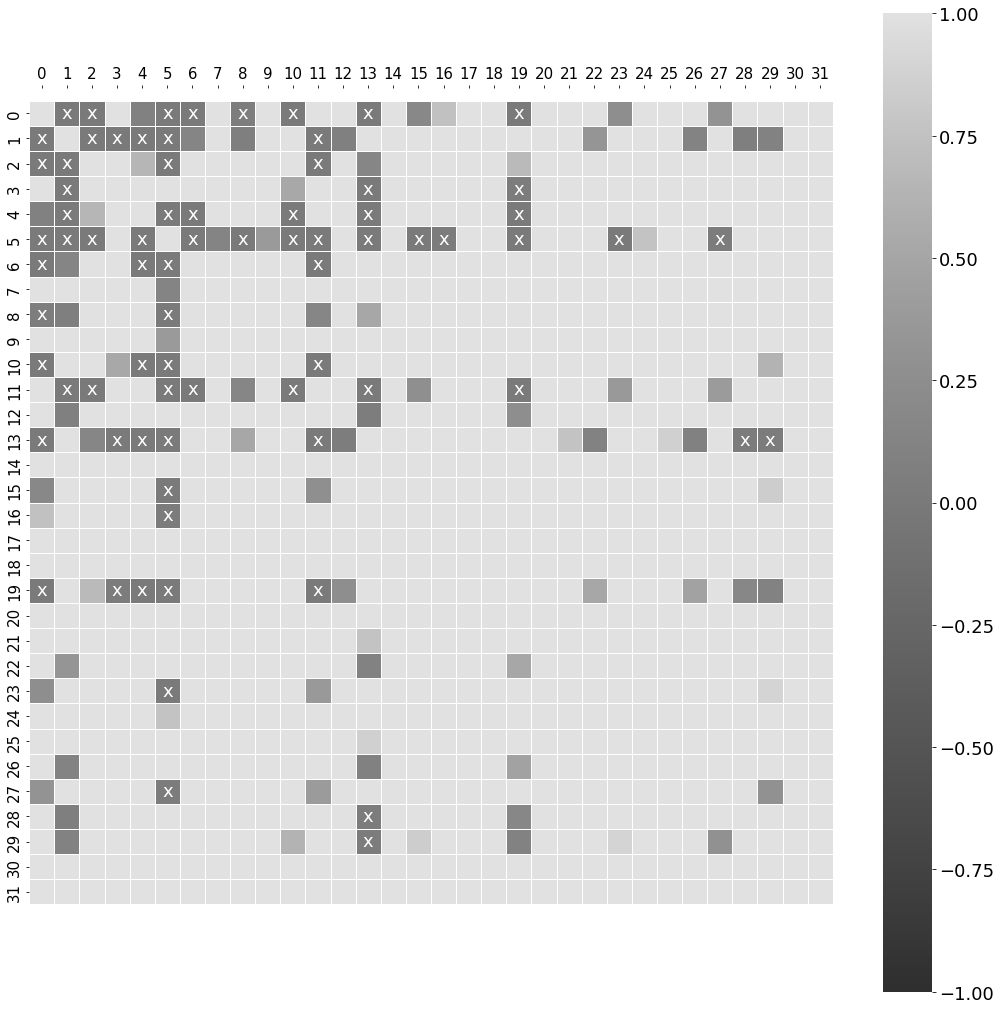

In [59]:
fig, ax = plt.subplots(figsize=(18,18)) 
# fig, ax = plt.subplots() 
plt.rcParams.update({'font.size': 18})
# ax = sns.heatmap(dunn_test, annot=mask, fmt="", square=True, vmin=-1, vmax=1, linewidths=0.5, ax=ax, cmap=plt.get_cmap('viridis'))
ax = sns.heatmap(dunn_test, annot=mask, fmt="", square=True, vmin=-1, vmax=1, linewidths=0.5, ax=ax, cmap=grayify_cmap('viridis'))
ax.xaxis.set_ticks_position('top')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

